c:\Users\manda\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\manda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


[0.8662431452274323, 0.9767529425621033, 0.9886588242053985]
0.9999993221363933 and 0.8814349549404147


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


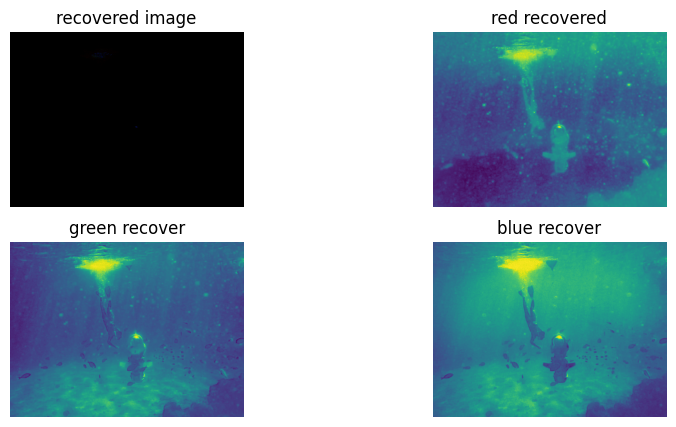

[0.005365791663582936, 0.9910385860994763, 0.9878995958839957]
0.9943245231674336 and 0.06424426156349271


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


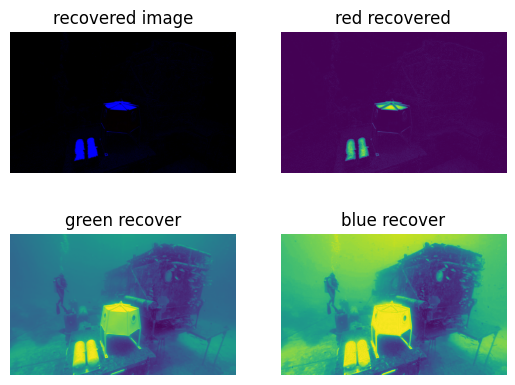

[0.7276801792058077, 0.8908454355868426, 0.8146040344780142]
0.9999524358147607 and 0.9944156057112608


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


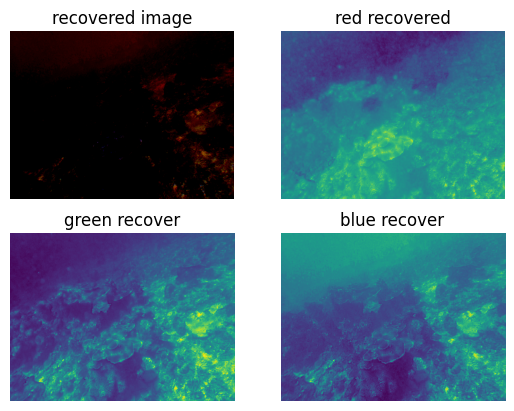

[0.6938705349442972, 0.9475433322327647, 0.877286776084805]
0.9999809064368687 and 0.8523957845754193


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


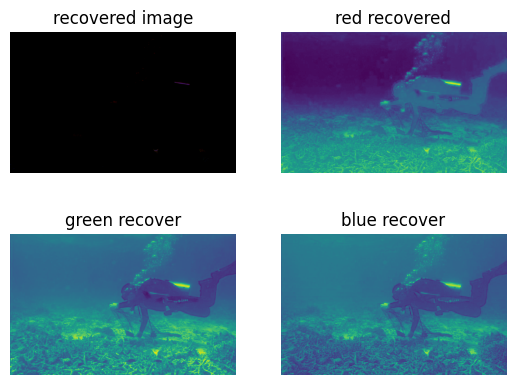

[0.9158740131367438, 0.7920804807740045, 0.7341991499168782]
0.9999568005186212 and 0.9999992587252248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


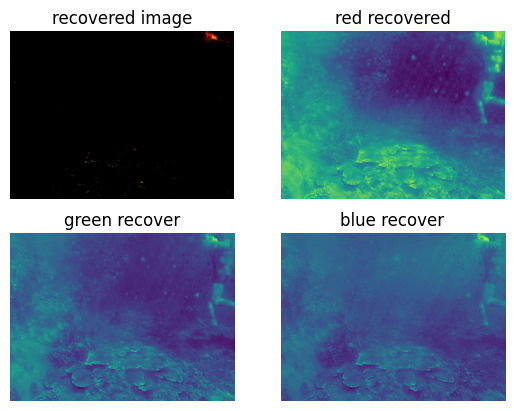

[0.9576062116771936, 0.9902287587523461, 0.9876225497573614]
0.9999997759837194 and 0.9307800697105915


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


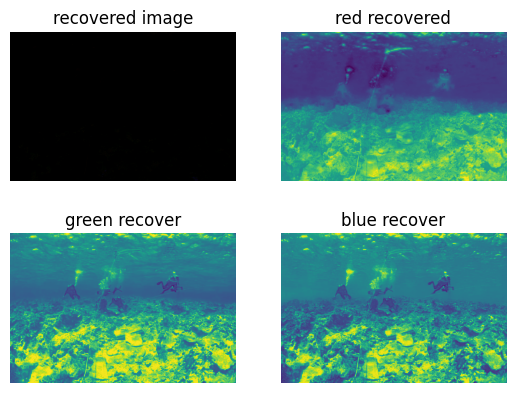

[0.5881589244712483, 0.886172657663172, 0.5991851524873213]
0.9978009137455045 and 0.9993717974910129


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


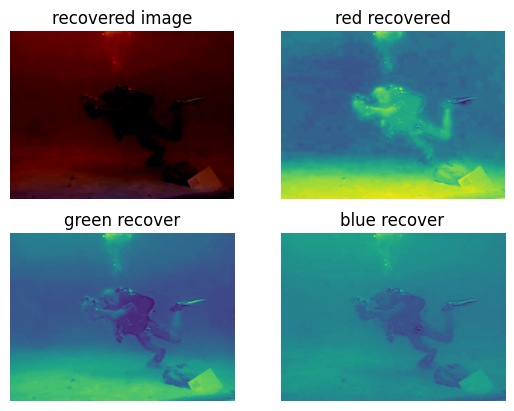

[0.974454180357304, 0.925607013195119, 0.465879583485583]
0.9999026111680227 and 0.9999909931086265


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


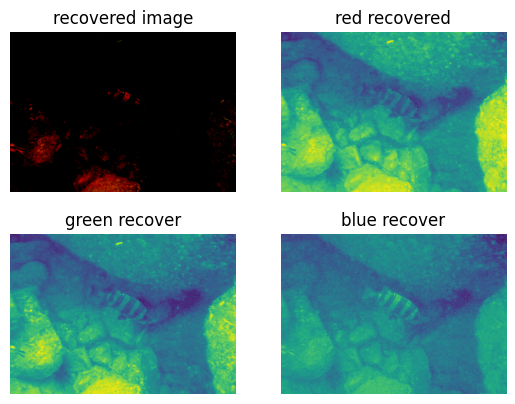

[0.8683968393321913, 0.8982507185541789, 0.5574817511913497]
0.9998478836330683 and 0.999614270351321


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


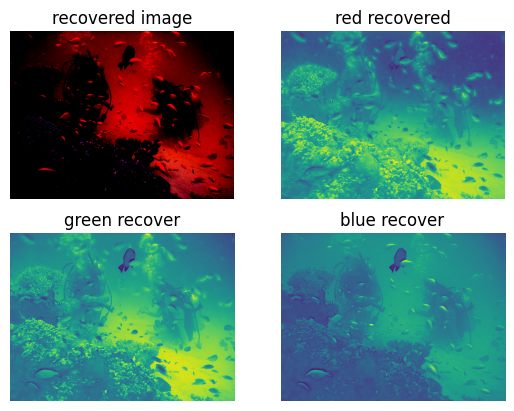

In [2]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

def Image_blurriness_Estimation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    n = 4
    P_init = np.empty(gray.shape, dtype=np.float32)
    
    for i in range(1, n+1):
        kernel_size = (2**i) * n + 1
        P_init[:, :] += np.abs(gray[:, :] - cv2.GaussianBlur(gray, (kernel_size, kernel_size), kernel_size))
    
    P_init /= n

    kernel = np.ones((7, 7), np.uint8)
    P_r=cv2.dilate(P_init, kernel)

    return P_r

def refine_blurriness_map(P_r):
    P_blr = np.empty(P_r.shape, dtype=np.float32)
    kernel = np.ones((7, 7), np.uint8)

    P_r = cv2.morphologyEx(P_r, cv2.MORPH_CLOSE, kernel)

    P_blr = cv2.boxFilter(P_r, -1, (7, 7), normalize=True)

    return P_blr

def QUAD_SELECT_LB(Ic, P_blr, epsilon, h_x,v_y, parent_w, parent_h):
    Igray = cv2.cvtColor(Ic, cv2.COLOR_BGR2GRAY).astype(np.float32)
    Iq = Igray
    
    while Iq.size / Igray.size > epsilon:
        
        height, width = Iq.shape
        h_half, w_half = height // 2, width // 2
        I1q = Iq[:h_half, :w_half]
        I2q = Iq[:h_half, w_half:]
        I3q = Iq[h_half:, :w_half]
        I4q = Iq[h_half:, w_half:]

        P_blr_1 = P_blr[:h_half, :w_half]
        P_blr_2 = P_blr[:h_half, w_half:]
        P_blr_3 = P_blr[h_half:, :w_half]
        P_blr_4 = P_blr[h_half:, w_half:]

        average_I1q = np.mean(P_blr_1)
        average_I2q = np.mean(P_blr_2)
        average_I3q = np.mean(P_blr_3)
        average_I4q = np.mean(P_blr_4)
        max_avg = max(average_I1q, average_I2q, average_I3q, average_I4q)
        if max_avg == average_I1q:
            # print('\nQuad: 1')
            Iq = I1q
            h_x=h_x-parent_w//4
            v_y = v_y-parent_h//4
            
        elif max_avg == average_I2q:
            # print('\nQuad 2')
            Iq = I2q
            h_x=h_x+parent_w//4
            v_y = v_y-parent_h//4

            
        elif max_avg == average_I3q:
            # print('\nQuad 3')
            Iq = I3q
            h_x=(h_x-parent_w//4)
            v_y = (v_y+parent_h//4)
            
        else:
            # print('\nQuad 4')
            Iq = I4q
            h_x=h_x+(parent_w//4)
            v_y = v_y+parent_h//4

        parent_h=parent_h/2
        parent_w=parent_w/2

    result=(h_x,v_y,parent_h,parent_w)
    x=result[0]
    y=result[1]
    width_2=result[3]
    height_2=result[2]

    return ((x-width_2//2,y-height_2//2),(x+width_2//2,y-height_2//2),(x-width_2//2,y+height_2//2),(x+width_2//2,y+height_2//2),width_2,height_2,Iq)


def QUAD_SELECT_LV(I, epsilon, h_x, v_y, parent_w, parent_h):
    Igray = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY).astype(np.float32)
    Iq = Igray
    
    while Iq.size / Igray.size > epsilon:
        
        height, width = Iq.shape
        h_half, w_half = height // 2, width // 2
        I1q = Iq[:h_half, :w_half]
        I2q = Iq[:h_half, w_half:]
        I3q = Iq[h_half:, :w_half]
        I4q = Iq[h_half:, w_half:]

        var_I1q = np.var(I1q)
        var_I2q = np.var(I2q)
        var_I3q = np.var(I3q)
        var_I4q = np.var(I4q)
        min_var = min(var_I1q, var_I2q, var_I3q, var_I4q)
        
        if min_var == var_I1q:
            Iq = I1q
            h_x -= parent_w // 4
            v_y -= parent_h // 4
            
        elif min_var == var_I2q:
            Iq = I2q
            h_x += parent_w // 4
            v_y -= parent_h // 4

            
        elif min_var == var_I3q:
            Iq = I3q
            h_x -= parent_w // 4
            v_y += parent_h // 4
            
        else:
            Iq = I4q
            h_x += parent_w // 4
            v_y += parent_h // 4

        parent_h /= 2
        parent_w /= 2

    result = (h_x, v_y, parent_h, parent_w)
    x = result[0]
    y = result[1]
    width_2 = result[3]
    height_2 = result[2]

    return ((x - width_2 // 2, y - height_2 // 2), 
            (x + width_2 // 2, y - height_2 // 2), 
            (x - width_2 // 2, y + height_2 // 2), 
            (x + width_2 // 2, y + height_2 // 2), width_2, height_2,Iq)


def sigmoid(a,v,s):
        return  1 / (1 + np.exp(-s * (a - v)))


def BL_Estimate(I,P_blr):
    epsilon=2**(-10)
    parent_w = I.shape[1]*1.0
    parent_h = I.shape[0]*1.0

    quad_coordinates_LB = QUAD_SELECT_LB(I, P_blr, epsilon, parent_w/2,parent_h/2, parent_w, parent_h)
    quad_coordinates_LV = QUAD_SELECT_LV(I, epsilon, parent_w / 2, parent_h / 2, parent_w, parent_h)

    r,g,b=cv2.split(I)

    quad_coordinates_LV_r=np.mean(r[round(quad_coordinates_LV[0][1]):round(quad_coordinates_LV[0][0]), round(quad_coordinates_LV[3][1]):round(quad_coordinates_LV[3][0])])
    quad_coordinates_LV_g=np.mean(g[round(quad_coordinates_LV[0][1]):round(quad_coordinates_LV[0][0]), round(quad_coordinates_LV[3][1]):round(quad_coordinates_LV[3][0])])
    quad_coordinates_LV_b=np.mean(b[round(quad_coordinates_LV[0][1]):round(quad_coordinates_LV[0][0]), round(quad_coordinates_LV[3][1]):round(quad_coordinates_LV[3][0])])

    
    quad_coordinates_LB_r=np.mean(r[round(quad_coordinates_LB[0][0]):round(quad_coordinates_LB[0][1]), round(quad_coordinates_LB[3][0]):round(quad_coordinates_LB[3][1])])
    quad_coordinates_LB_g=np.mean(g[round(quad_coordinates_LB[0][0]):round(quad_coordinates_LB[0][1]),round(quad_coordinates_LB[3][0]):round(quad_coordinates_LB[3][1])])
    quad_coordinates_LB_b=np.mean(b[round(quad_coordinates_LB[0][0]):round(quad_coordinates_LB[0][1]), round(quad_coordinates_LB[3][0]):round(quad_coordinates_LB[3][1])])

    h, w = I.shape[:2]
    imsz = h * w
    numpx = max(math.ceil(imsz * 0.001), 1)
    darkvec = I[..., 0].reshape(imsz)
    imvec = I.reshape(imsz, 3)
    indices = darkvec.argsort()[-numpx:]
    atmsum = np.zeros([1, 3])
    for ind in indices:
        atmsum += imvec[ind]


    B_cand_1=[quad_coordinates_LV_r,quad_coordinates_LV_g,quad_coordinates_LV_b]
    B_cand_2=[quad_coordinates_LB_r,quad_coordinates_LB_g,quad_coordinates_LB_b]
    B_cand_3 = atmsum[0] / numpx



    B_max=[]
    B_min=[]


    if np.any(np.isnan(B_cand_1)) or np.any(np.isnan(B_cand_2)):
        B_max = B_cand_3
        B_min = B_cand_3

    else:
        for i in range (0,3):
            maxi=max(max(B_cand_1[i],B_cand_2[i]),B_cand_3[i])
            B_max.append(maxi)

        for i in range (0,3):
            mini=min(min(B_cand_1[i],B_cand_2[i]),B_cand_3[i])
            B_min.append(mini)

    
    # print(B_cand_1)
    # print(B_cand_2)
    # print(B_cand_3)
    # print(B_max)
    # print(B_min)


    final_BL=[0,0,0]
    for channel in range(3):
        I_channel = I[:, :, channel] 
        a = np.sum(I_channel > 0.5) 
        v = I_channel.size  
        s = 32 
        epsilon_n=0.2
        alpha = sigmoid(a/v,epsilon_n , s) 
        final_BL[channel]=alpha*B_max[channel]+(1-alpha)*B_min[channel]


    # print(r)
    # print("green")

    # print(g)
    # print("blue")

    # print(b)


    return final_BL

def stretching_function(X):
    X_min = np.min(X)
    X_max = np.max(X)
    # print("min",X_min)
    # print("max",X_max)

    stretched_X = (X - X_min)  / (X_max - X_min)
    return stretched_X



def Depth_Estimation(I,P_r,BL):
    r,g,b=cv2.split(I)
    kernel = np.ones((7, 7), np.uint8)
    R=cv2.dilate(r, kernel)

    d_R=1-stretching_function(R)


    max_green_blue=cv2.max(b,g)
    D_mip= cv2.dilate(r,kernel)-cv2.dilate(max_green_blue, kernel)

    d_D=1-stretching_function(D_mip)
    
    d_B=1-stretching_function(cv2.morphologyEx(P_r, cv2.MORPH_CLOSE, kernel))

    s=32
    theta_a=sigmoid(np.mean(BL),0.5,s)
    theta_b=sigmoid(np.mean(r),0.1,s)

    print(BL)

    print(theta_a,"and",theta_b)

    # print("average I_r",np.mean(r))
    # print("average BL",np.mean(BL))


    d_n = theta_b * (theta_a * d_D + (1 - theta_a) * d_R) + (1 - theta_b) * d_B

    return d_n

def TM_Estimation(I,BL,d_n):
  
    r, g, b = cv2.split(I)
    # r_max = r.max()
    # r_min = r.min()
    # g_max = g.max()
    # g_min = g.min()
    # b_max = b.max()
    # b_min = b.min()

    # print("Red channel - Max:", r_max, "Min:", r_min)
    # print("Green channel - Max:",g_max, "Min",g_min)
    # print("blue channel - Max:",b_max, "Min",b_min)

    # max_value = 0
    # for channel, ref_value in zip([r, g, b], BL):
    #     for pixel in channel.flat:
    #         abs_diff = abs(ref_value - pixel)
    #         print(abs_diff)
    #         max_value = np.argmax(int(max_value), int(abs_diff))


    # k=max_value

    max_red=0
    max_green=0
    max_blue=0

    for i in range (len(r)):
            for j in range(len(r[0])):
                abs_diff = abs(BL[0] - r[i][j])
                max_red=max(max_red,abs_diff)

    for i in range (len(g)):
            for j in range(len(g[0])):
                abs_diff = abs(BL[1] - g[i][j])
                max_green=max(max_green,abs_diff)

    for i in range (len(b)):
            for j in range(len(b[0])):
                abs_diff = abs(BL[2] - b[i][j])
                max_blue=max(max_blue,abs_diff)

    max_of_all=max(max_blue,max(max_red,max_green))
    
    BL_k=0
    if(max_of_all==max_red):
        BL_k=BL[0]
    elif(max_of_all==max_green):
        BL_k=BL[1]
    elif(max_of_all==max_blue):
        BL_k=BL[2]

    max_red = 0
    max_green=0
    max_blue=0

    for i in range (len(r)):
        for j in range(len(r[0])):
            abs_diff = abs(BL[0] - r[i][j])
            denominator = max(BL_k, 1 - BL_k) 
            red_difference = abs_diff / denominator
            max_red = max(max_red, red_difference)

    for i in range (len(g)):
        for j in range(len(g[0])):
            abs_diff = abs(BL[1] - g[i][j])
            denominator = max(BL_k, 1 - BL_k) 
            green_difference = abs_diff / denominator
            max_green = max(max_red, green_difference)

    for i in range (len(b)):
        for j in range(len(b[0])):
            abs_diff = abs(BL[2] - b[i][j])
            denominator = max(BL_k, 1 - BL_k) 
            blue_difference = abs_diff / denominator
            max_blue = max(max_red, blue_difference)

    d_0=1-max(max(max_blue,max_green),max_red)


    D_infinity=8
    d_F=D_infinity*(d_0+d_n)


    beta_r=1/7

    m = -0.00113
    i = 1.62517

    red_TM=np.exp(-beta_r * d_F)
    green_TM=red_TM**(BL[0]*(m*540+i)/BL[1]*(m*620+i))
    blue_TM=red_TM**(BL[0]*(m*450+i)/BL[2]*(m*620+i))

    # print("red transmission")
    # print(red_TM)

    # print("green transmission")

    # print(green_TM)
    # print("blue transmission")

    # print(blue_TM)


    return [red_TM,green_TM,blue_TM]



def plotting_box(quad_coordinates,I):

    plt.imshow(I)
    rectangle = patches.Rectangle(quad_coordinates[0], quad_coordinates[4], quad_coordinates[5], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rectangle)
    plt.axis('off')

def Guidedfilter(im, p, r, eps):
    mean_I = cv2.GaussianBlur(im,(r, r),1)
    mean_p = cv2.GaussianBlur(p, (r, r),1)
    mean_Ip = cv2.GaussianBlur(im * p, (r, r),1)
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.GaussianBlur(im * im,(r, r),1)
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.GaussianBlur(a,(r, r),1)
    mean_b = cv2.GaussianBlur(b,(r, r),1)

    q = mean_a * im + mean_b
    return q

def TransmissionRefine(image, et):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray) / 255
    r = 61
    eps = 0.0001
    t = Guidedfilter(gray, et, r, eps)

    return t

def Recover(im, t, A,ind, tx=0.1):
    res = np.empty(t.shape, t.dtype)
    t = cv2.max(t, tx)

    res[:, :] = (im[:, :, ind] - A[ind]) / t + (1-A[ind])*A[ind]

    return res

plt.figure(figsize=(10, 5))



# folder_path = "C://College Projects//Applied LA for ML//5426a351-39e9-478c-8775-5fbcd69d30e5//raw//raw-890"
folder_path= "C://College Projects//Applied LA for ML//Images_for_DCP"


for filename in os.listdir(folder_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):  # Adjust based on the file types in your folder
        file_path = os.path.join(folder_path, filename)
        
        # Load the image
        src = cv2.imread(file_path)

        # fn = 'C://College Projects//Applied LA for ML//5426a351-39e9-478c-8775-5fbcd69d30e5//raw//raw-890//827_img_.png'
        # src = cv2.imread(fn)
        image = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
        I = image.astype('float32') / 255

        P_r = Image_blurriness_Estimation(I)
        P_blr = refine_blurriness_map(P_r)

        BL=BL_Estimate(I,P_blr)
        D_E=Depth_Estimation(I,P_blr,BL)
        T_E=TM_Estimation(I,BL,D_E)

        refine_t_r = TransmissionRefine(src, T_E[0])
        refine_t_g = TransmissionRefine(src, T_E[1])
        refine_t_b = TransmissionRefine(src, T_E[2])


        red_recover = Recover(I, refine_t_r, BL, 0, 0.1)
        green_recover = Recover(I, refine_t_g, BL, 1, 0.1)
        blue_recover = Recover(I, refine_t_b, BL, 2, 0.1)

        # red_recover = Recover(I, T_E[0], BL, 0, 0.1)
        # green_recover = Recover(I, T_E[1], BL, 1, 0.1)
        # blue_recover = Recover(I,T_E[2], BL, 2, 0.1)

        recovered_image = cv2.merge([blue_recover, green_recover,red_recover])

        plt.subplot(2, 2, 1)
        plt.imshow(recovered_image)
        plt.title('recovered image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(red_recover)
        plt.title('red recovered')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(green_recover)
        plt.title('green recover')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(blue_recover)
        plt.title('blue recover')
        plt.axis('off')



        plt.show()


